ダウンロード

In [1]:
#import
from yahoo_fin import stock_info
import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


S&P500の中から銘柄をいくつかダウンロード　

In [25]:
## まずは、S&P500にどんな銘柄が含まれているかを読み込む
# Download whatever ticker you like and perform anomaly detection

def fetch_sp500_tickers():
    # Fetch the S&P 500 table from the Wikipedia page
    table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    sp500_df = table[0]  # The first table is usually the S&P 500 constituents

    # Extract the 'Symbol' column
    tickers = sp500_df['Symbol'].tolist()
    
    return tickers

# Get S&P 500 tickers
tickers = fetch_sp500_tickers()
tickers.sort()



In [26]:
# S&P500の中から複数銘柄のダウンロード
list_stock = []
# If you want you can download the entire SP500 
#for kkk in range(len(df_sp)):
for k in range(5):
    if k % 100 == 0:
        print(k)
        
    ticker = tickers[k]
    print(ticker)
    stock_price = yf.download(ticker, period="max")
    stock_price["ticker"] = ticker
    
    list_stock.append(stock_price)
    
# df_stockの末尾に "ticker" という欄を作る
df_stock = pd.concat(list_stock)


0
A


[*********************100%%**********************]  1 of 1 completed


AAL


[*********************100%%**********************]  1 of 1 completed


AAPL


[*********************100%%**********************]  1 of 1 completed


ABBV


[*********************100%%**********************]  1 of 1 completed


ABNB


[*********************100%%**********************]  1 of 1 completed


In [27]:
# 取り出した５つの中から 名前がAのものを出してくる

cond = df_stock["ticker"] == "A"
df_tmp =df_stock.loc[cond]

#表示してみる
df_tmp

長い時系列データを個別に取得する

In [44]:
#長い時系列のデータを取得
#名前は (https://finance.yahoo.com) から持ってくる

## S&P500を対象とする　set ticker symbol ^GSPC = SP500
#ticker = "^GSPC"

## NVDIA
ticker = "NVDA"

## MicroSoft
#ticker = "MSFT"

## ネトフリ
#ticker = "NFLX"

df = yf.download(ticker, period="max")

[*********************100%%**********************]  1 of 1 completed


In [4]:
# 収益率を計算
# 対数収益率に注目

# Calculate return
df['Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
# This is another way to calculate return
#df['Return'] = df["Adj Close"].pct_change(1).mul(100)

df["Volatility"] = df.Return.abs()   

# Drop NA
df.dropna(inplace=True)

異常検知コード

In [5]:
#過去の振る舞いから考えて正常とは考えにくい稀な事象を判定
#移動平均と移動標準偏差を用いる
# Resort the dataframe
df.sort_values(by="Date",ascending=True,inplace=True)
# Calculate the moving average and standard deviation
window_size = 90
df['Moving Average'] = df["Return"].rolling(window=window_size).mean()
df['Standard Deviation'] = df['Return'].rolling(window=window_size).std()
df.dropna(inplace=True)

#異常検知コード
#閾値は6.0（この値の分だけ標準偏差異常平均から離れたら異常値と判定）
# Set the threshold for anomaly detection
threshold = 6.0
df['Lower Bound'] = df['Moving Average'] - (df['Standard Deviation'] * threshold)
df['Upper Bound'] = df['Moving Average'] + (df['Standard Deviation'] * threshold)

# Identify the anomalies
df['Anomaly'] = np.where((df['Return'] > df['Upper Bound']) | (df['Return'] < df['Lower Bound']), 1, 0)

描画する

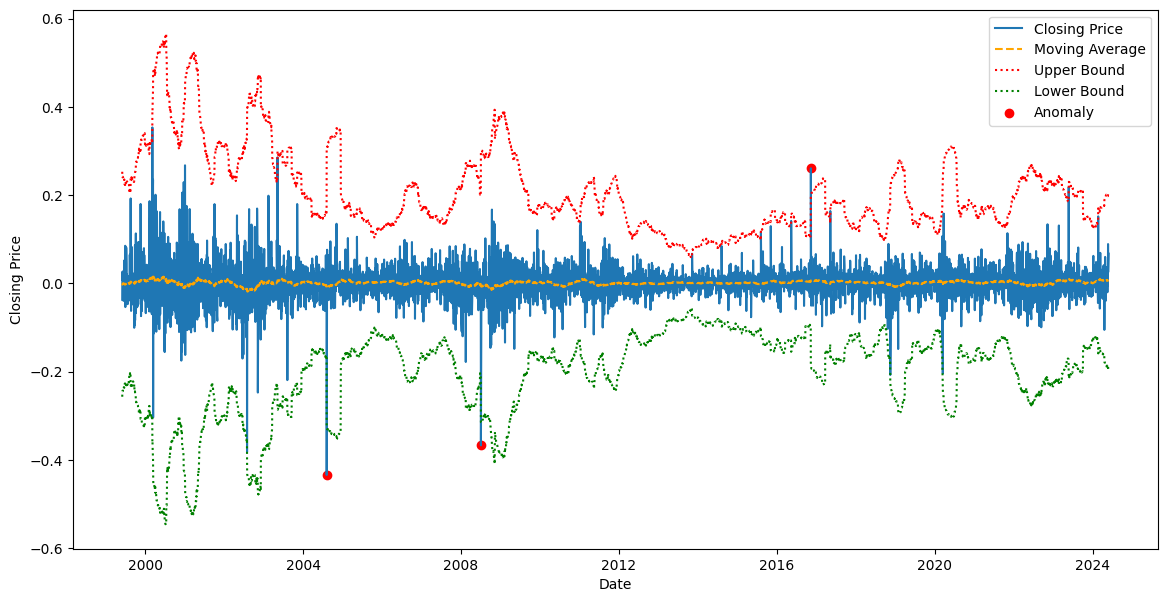

                 Open       High     Low      Close  Adj Close     Volume  \
Date                                                                        
2004-08-06   0.842500   0.850000   0.775   0.785833   0.720846  508894800   
2008-07-03   3.245000   3.282500   3.100   3.122500   2.864276  298752000   
2016-11-11  19.877501  22.192499  19.625  21.992500  21.643080  217534400   

              Return  Volatility  Moving Average  Standard Deviation  \
Date                                                                   
2004-08-06 -0.434382    0.434382       -0.011009            0.052480   
2008-07-03 -0.367109    0.367109       -0.006540            0.051346   
2016-11-11  0.260876    0.260876        0.006547            0.032318   

            Lower Bound  Upper Bound  Anomaly  
Date                                           
2004-08-06    -0.325889     0.303870        1  
2008-07-03    -0.314615     0.301536        1  
2016-11-11    -0.187361     0.200456        1  


In [6]:
#異常検知のコード
#移動平均と移動標準偏差を用いて4.5標準偏差異常平均から離れたら異常値と判定
# Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(df['Return'], label='Closing Price')
plt.plot(df['Moving Average'], label='Moving Average', linestyle='dashed', color='orange')
plt.plot(df['Upper Bound'], label='Upper Bound', linestyle='dotted', color='red')
plt.plot(df['Lower Bound'], label='Lower Bound', linestyle='dotted', color='green')
plt.scatter(df[df['Anomaly'] == 1].index, df[df['Anomaly'] == 1]['Return'], color='red', marker='o', label='Anomaly')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# 異常検知された日付をprint
# Print the anomalies
print(df[df['Anomaly'] == 1])

クラスにまとめてみる

In [39]:
#import
from yahoo_fin import stock_info
import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle

class AnomalyDetector:
    def __init__(self,df,window_size=90,threshold=6.0) -> None:
        self.df = df.copy()
        self.windowsize = window_size
        self.threshold = threshold
        self.preprocess_data()
        self.detect_anomalies()
        
    def preprocess_data(self):
        # Calculate return
        self.df['Return'] = np.log(self.df['Adj Close'] / self.df['Adj Close'].shift(1))
        self.df["Volatility"] = self.df.Return.abs()
        
        # Drop NA
        self.df.dropna(inplace=True)

        # Resort the dataframe
        self.df.sort_values(by="Date", ascending=True, inplace=True)
        
        # Calculate the moving average and standard deviation
        self.df['Moving Average'] = self.df["Return"].rolling(window=self.windowsize).mean()
        self.df['Standard Deviation'] = self.df['Return'].rolling(window=self.windowsize).std()
        self.df.dropna(inplace=True)

        
    def detect_anomalies(self):
        # Set the threshold for anomaly detection
        self.df['Lower Bound'] = self.df['Moving Average'] - (self.df['Standard Deviation'] * self.threshold)
        self.df['Upper Bound'] = self.df['Moving Average'] + (self.df['Standard Deviation'] * self.threshold)
        
        # Identify the anomalies
        self.df['Anomaly'] = np.where((self.df['Return'] > self.df['Upper Bound']) | (self.df['Return'] < self.df['Lower Bound']), 1, 0)
        
    def plot_results(self):
        plt.figure(figsize=(14, 7))
        plt.plot(self.df['Return'], label='Return')
        plt.plot(self.df['Moving Average'], label='Moving Average', linestyle='dashed', color='orange')
        plt.plot(self.df['Upper Bound'], label='Upper Bound', linestyle='dotted', color='red')
        plt.plot(self.df['Lower Bound'], label='Lower Bound', linestyle='dotted', color='green')
        plt.scatter(self.df[self.df['Anomaly'] == 1].index, self.df[self.df['Anomaly'] == 1]['Return'], 
                    color='red', marker='o', label='Anomaly')
        plt.xlabel('Date')
        plt.ylabel('Return')
        plt.legend()
        plt.show()
        
    def print_anomalies(self):
        # Print the anomalies
        anomalies = self.df[self.df['Anomaly'] == 1]
        print(anomalies)
        

# NVIDIA

[*********************100%%**********************]  1 of 1 completed


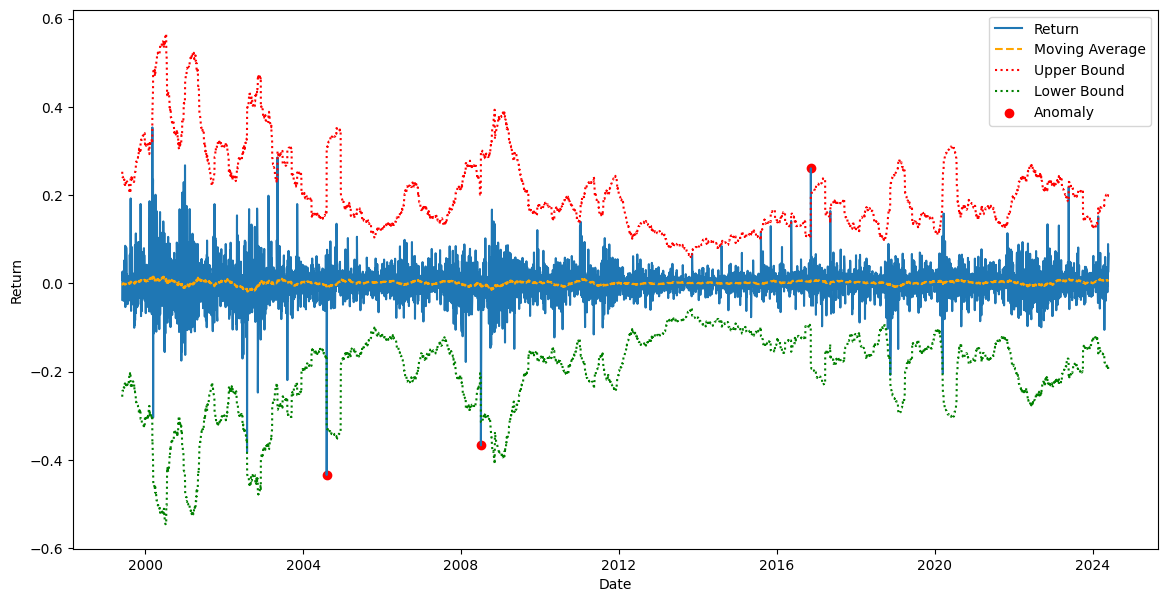

                 Open       High     Low      Close  Adj Close     Volume  \
Date                                                                        
2004-08-06   0.842500   0.850000   0.775   0.785833   0.720846  508894800   
2008-07-03   3.245000   3.282500   3.100   3.122500   2.864276  298752000   
2016-11-11  19.877501  22.192499  19.625  21.992500  21.643082  217534400   

              Return  Volatility  Moving Average  Standard Deviation  \
Date                                                                   
2004-08-06 -0.434383    0.434383       -0.011009            0.052480   
2008-07-03 -0.367109    0.367109       -0.006540            0.051346   
2016-11-11  0.260876    0.260876        0.006547            0.032318   

            Lower Bound  Upper Bound  Anomaly  
Date                                           
2004-08-06    -0.325889     0.303870        1  
2008-07-03    -0.314615     0.301536        1  
2016-11-11    -0.187361     0.200456        1  


In [40]:
## NVDIA
ticker = "NVDA"
df = yf.download(ticker, period="max")

dt = AnomalyDetector(df)
dt.plot_results()
dt.print_anomalies()

NVIDIA まとめ

2004-08-06  
NVIDIA's stock experienced a significant drop following the announcement of their Q2 earnings for fiscal year 2005. 
The market reacted negatively due to concerns over the competitive pressure from ATI Technologies and potential impacts on future earnings.  

2008-07-03  
NVIDIA announced a substantial charge related to warranty costs due to defects in certain notebook chip.
This announcement caused considerable concern among investors about the financial impact and the potential loss of market confidence​.

2016-11-11  
NVIDIA’s stock price surged following the release of its Q3 fiscal 2017 results, which significantly surpassed expectations.The company reported a 54% increase in revenue year-over-year, driven by strong performance in gaming, data centers, and automotive sectors. NVIDIA’s GPUs were increasingly being adopted for AI and machine learning applications, which contributed to investor optimism and a boost in the stock price​ 

 

# MicroSoft

[*********************100%%**********************]  1 of 1 completed


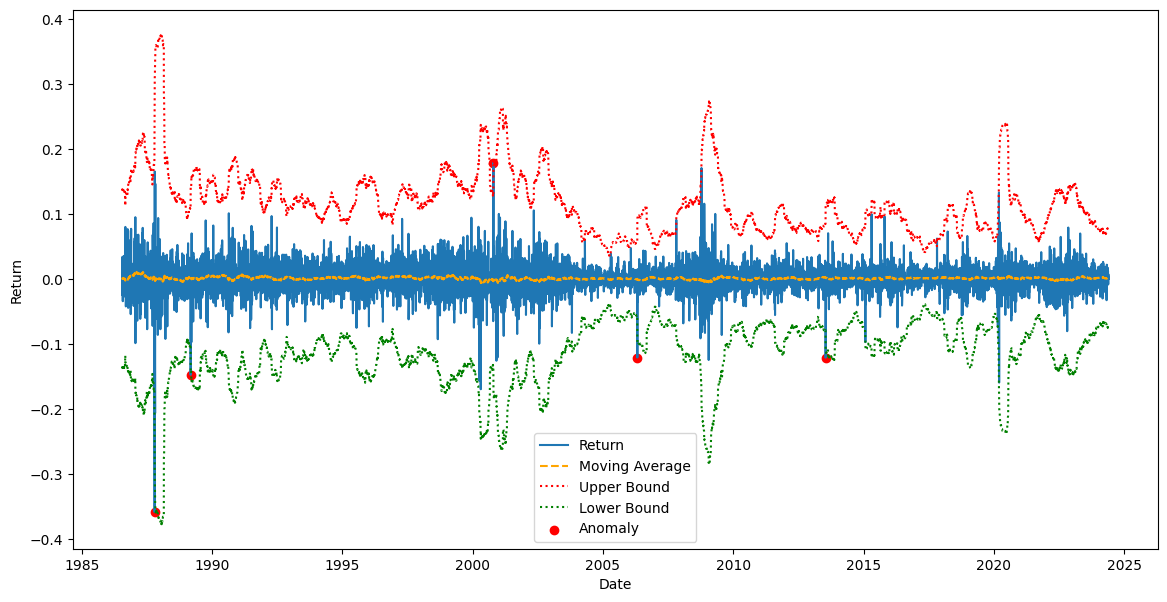

                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
1987-10-19   0.427083   0.440972   0.312500   0.314236   0.194105  146880000   
1989-03-07   0.414931   0.416667   0.369792   0.371528   0.229495  788688000   
2000-10-19  29.218750  31.093750  29.000000  30.937500  19.110260  256993200   
2006-04-28  24.230000  24.500000  24.000000  24.150000  17.085880  591052200   
2013-07-19  32.400002  32.669998  31.020000  31.400000  25.963011  248428500   

              Return  Volatility  Moving Average  Standard Deviation  \
Date                                                                   
1987-10-19 -0.358332    0.358332       -0.000828            0.047896   
1989-03-07 -0.147453    0.147453        0.000807            0.023570   
2000-10-19  0.178692    0.178692       -0.001028            0.029439   
2006-04-28 -0.120769    0.120769       -0.001161            0.015757   
2013-07

In [41]:
## MicroSoft
ticker = "MSFT"
df = yf.download(ticker, period="max")

dt = AnomalyDetector(df)
dt.plot_results()
dt.print_anomalies()

Microsoft まとめ  

1987-10-19  
This date is known as "Black Monday," a major stock market crash that affected many companies, including Microsoft.  

1989-03-07  
Microsoft announced the introduction of Word for Windows, a major step in its software offerings that contributed significantly to its dominance in the software market.

2000-10-19  
Due to the tech bubble burst. 
This date marked a period when tech stocks, including Microsoft, experienced significant declines.

2006-04-28  
This date doesn't coincide with any specific major event for Microsoft. However, it falls in a period where Microsoft was gearing up for the launch of Windows Vista, which was released to business customers later in 2006 and to consumers in early 2007.

2013-07-19  
On this day, Microsoft experienced its largest one-day percentage sell-off since the year 2000. 
The company's fourth-quarter report raised concerns among investors due to poor performance in its Surface tablet line and Windows 8, leading to a loss of over $32 billion in market value


# NETFLIX

[*********************100%%**********************]  1 of 1 completed


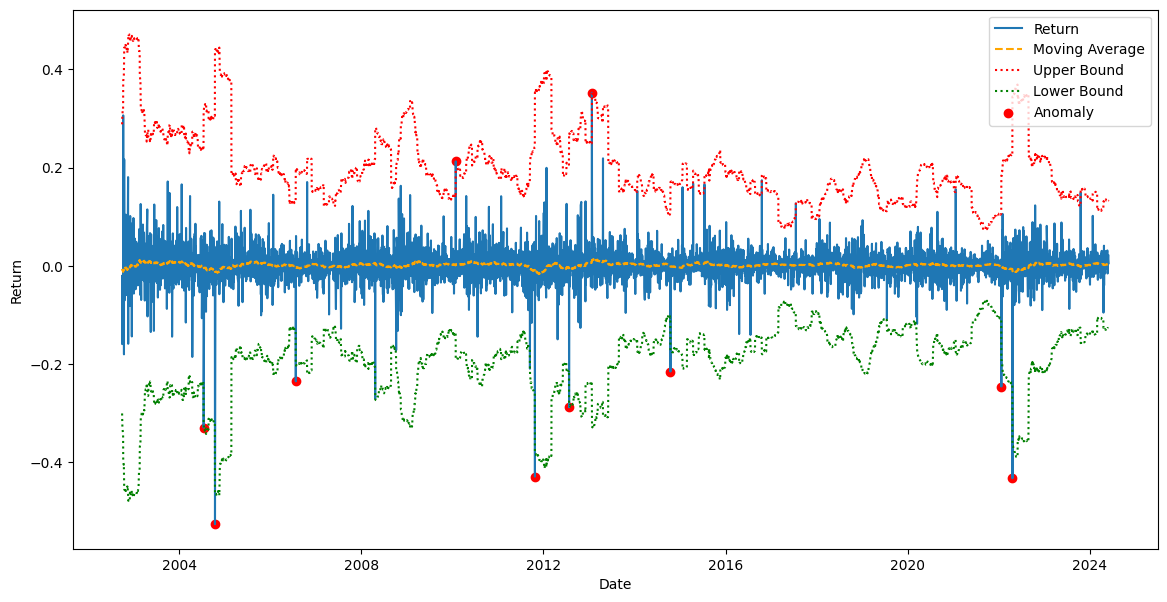

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2004-07-16    3.834286    3.871429    3.265714    3.288571    3.288571   
2004-10-15    1.432857    1.641429    1.422857    1.471429    1.471429   
2006-07-25    2.712857    2.762857    2.655714    2.682857    2.682857   
2010-01-28    8.812857    9.121429    8.675714    9.005714    9.005714   
2011-10-25   10.700000   11.341429   10.607143   11.052857   11.052857   
2012-07-25    9.172857    9.542857    8.457143    8.611429    8.611429   
2013-01-24   20.570000   21.309999   19.945715   20.980000   20.980000   
2014-10-16   47.532856   52.310001   47.285713   51.671429   51.671429   
2022-01-21  400.429993  409.149994  379.989990  397.500000  397.500000   
2022-04-20  245.199997  248.699997  212.509995  226.190002  226.190002   

               Volume    Return  Volatility  Moving Average  \
Date                                            

In [42]:
## ネトフリ
ticker = "NFLX"
df = yf.download(ticker, period="max")

dt = AnomalyDetector(df)
dt.plot_results()
dt.print_anomalies()

NETFLIX まとめ



2004-07-16  
Netflix announced a new pricing strategy, lowering the monthly subscription fee from $21.99 to $17.99. This move was part of a strategy to attract more customers and compete effectively against Blockbuster​.

2004-10-15  
Netflix reported its third-quarter earnings. The company saw significant growth in subscriber numbers, attributing the success to their aggressive pricing and marketing strategies​.

2006-07-25  
Netflix announced its second-quarter financial results for 2006. The company reported substantial growth in revenue and subscriber base, continuing its trend of robust performance​.

2010-01-28  
Netflix posted its fourth-quarter results for 2009, revealing an impressive increase in subscriber numbers and revenue, driven by the growing popularity of its streaming service​.

2011-10-25  
Netflix reported a significant drop in subscribers and stock price following a controversial decision to separate its streaming and DVD rental services into two different plans, which had not been well-received by customers​.

2012-07-25  
Netflix released its second-quarter earnings, showing a slower growth rate compared to previous quarters. The company was in a transitional phase, focusing more on expanding its streaming content library.

2013-01-24  
The company announced its fourth-quarter results for 2012, showing a rebound in subscriber growth and profitability, largely due to popular original content like "House of Cards"​.

2014-10-16  
Netflix announced its third-quarter results for 2014, revealing a slower-than-expected subscriber growth, which led to a significant drop in its stock price. The market reaction highlighted concerns about increased competition and market saturation​.

2022-01-21  
Netflix reported its fourth-quarter 2021 earnings, which showed slower subscriber growth than anticipated. This was a critical moment for the company as it faced increasing competition from other streaming services​.

2022-04-20  
Netflix revealed its first-quarter 2022 results, showing a loss in subscribers for the first time in over a decade. This announcement caused a major decline in its stock price and led to discussions about the company's future strategy and market position​.
